In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss,accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数

In [2]:
filePath = "../Kaggle_Dataset/car-consume/measurements.csv"
df = pd.read_csv(filePath, decimal=',')
display(df.head())
df.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [3]:
#不要列削除
df = df.drop(columns="specials")
df = df.drop(columns="refill liters")
df = df.drop(columns="refill gas")

In [4]:
#外気温内気温のnan値の行を削除
colName="temp_inside"
df = df[~np.isnan(df[colName])]  #nan値の削除

In [5]:
#燃料種別を数値に変換
colName="gas_type"
df[colName] = df[colName].replace('E10' ,0)
df[colName] = df[colName].replace('SP98' ,1)
df[colName]=pd.to_numeric(df[colName], errors="coerce")
df[colName].value_counts()

1    219
0    157
Name: gas_type, dtype: int64

In [6]:
#気温差列を追加してみる
df["tempDiff"] = abs(df["temp_outside"]-df["temp_inside"])
#気温の差が高いほどエアコンによるエネルギーロスが発生していると仮定

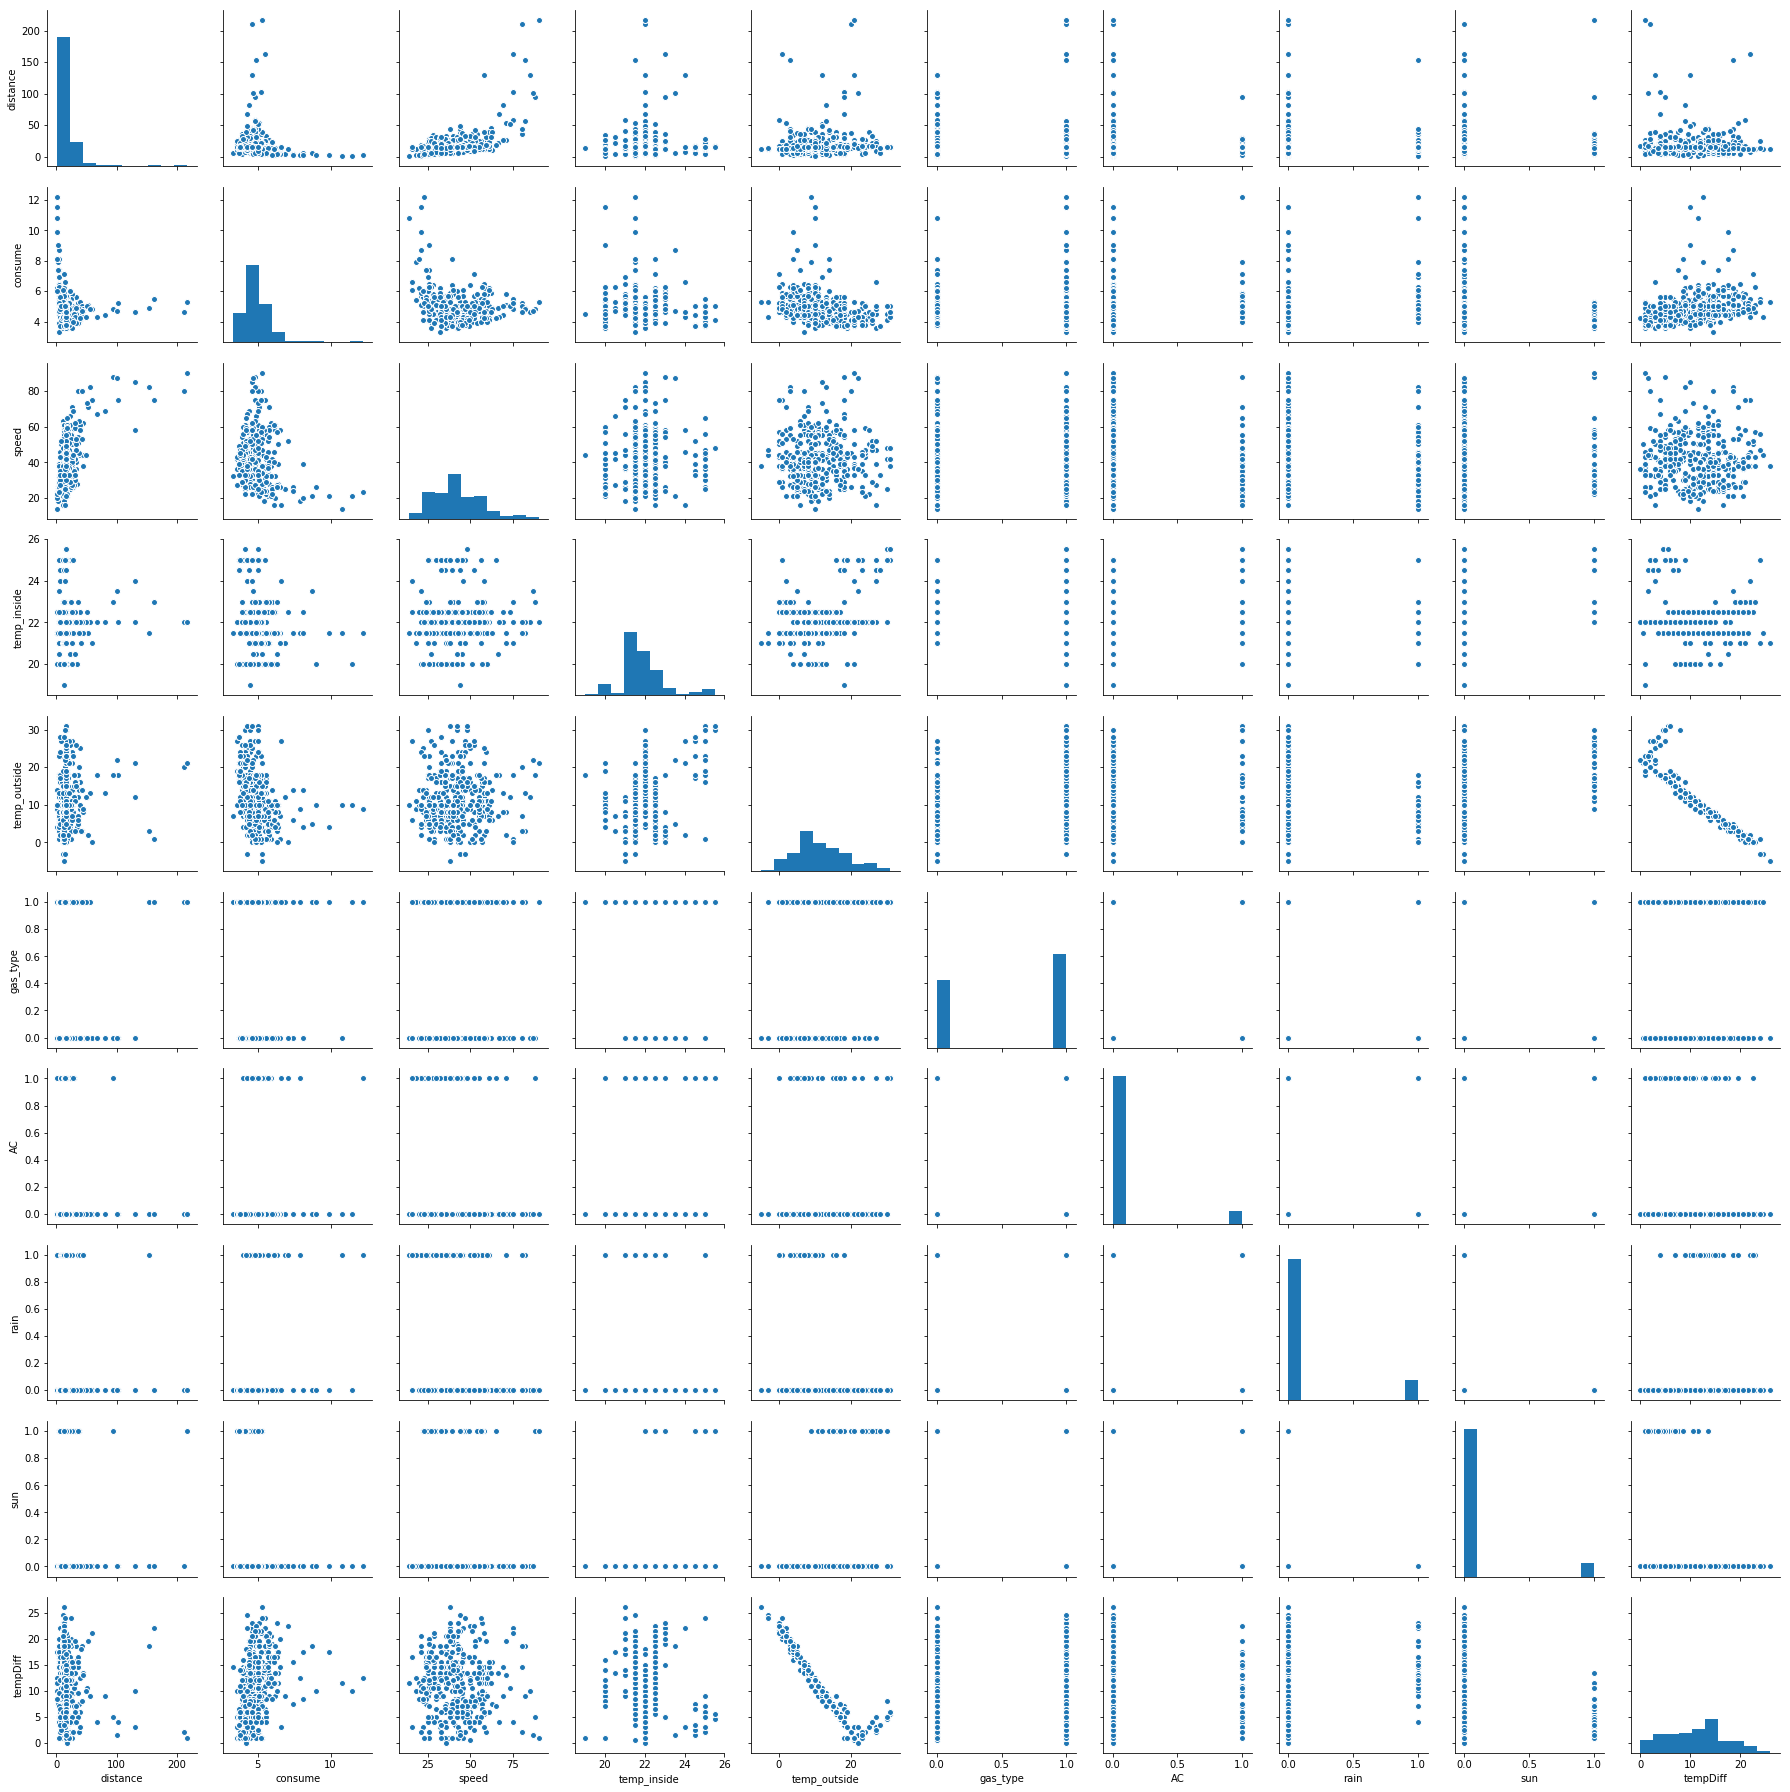

In [7]:
#散布図行列
sns.pairplot(df)

plt.show()
#temp_insideが人間にとって過ごしやすい温度22度周辺に近くなるよう、エアコンで操作している事がtemp_outsideとtempDiffの散布図から分かる。
#散布図から、tempDiffとconsumeが僅かに相関しているように見える。
#distanceとconsume, speedとconsumeの散布図から、燃費は短距離＜長距離、低速＜高速　という負の相関が僅かにある。
#一般的な車両特性として、停止発進回数の多い街乗りより、長距離をノンストップで移動したほうが、燃費は良いためと考えられる。

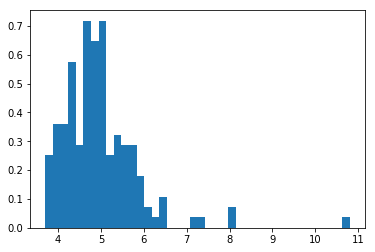

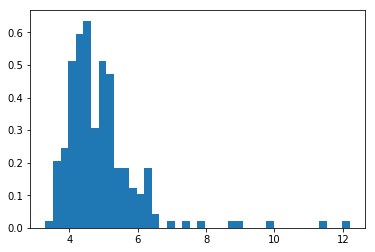

In [8]:
#ガソリン種類に応じたグラフの表示
df_E10=df[df["gas_type"]==0]
df_SP=df[df["gas_type"]==1]

plt.hist(df_E10["consume"],normed=True,bins=40)
plt.show()
plt.hist(df_SP["consume"],normed=True,bins=40)
plt.show()
#ヒストグラムからでは燃費の良い方を判断するのは困難

In [9]:
#相関係数
df_corr=df.corr()
print(df_corr)
#tempDiffとconsumeが僅かな相関0.3程度を示していることから、エアコンの操作が燃費に関係していると考えられる。

              distance   consume     speed  temp_inside  temp_outside  \
distance      1.000000 -0.131379  0.565505     0.075305      0.086774   
consume      -0.131379  1.000000 -0.234537    -0.161991     -0.318758   
speed         0.565505 -0.234537  1.000000     0.059725      0.019327   
temp_inside   0.075305 -0.161991  0.059725     1.000000      0.361308   
temp_outside  0.086774 -0.318758  0.019327     0.361308      1.000000   
gas_type     -0.047877 -0.020928 -0.099495     0.010340      0.156990   
AC           -0.027670  0.093892 -0.036351     0.297775      0.169374   
rain         -0.022129  0.247699 -0.002936    -0.037356     -0.185731   
sun           0.078627 -0.169173  0.077181     0.246120      0.349988   
tempDiff     -0.103673  0.312452 -0.029385    -0.150228     -0.938296   

              gas_type        AC      rain       sun  tempDiff  
distance     -0.047877 -0.027670 -0.022129  0.078627 -0.103673  
consume      -0.020928  0.093892  0.247699 -0.169173  0.312452  
s

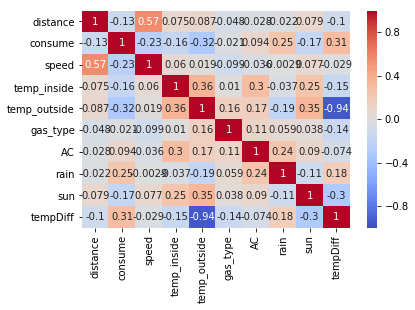

In [10]:
#相関係数ヒートマップ
sns.heatmap(df_corr,cmap="coolwarm",vmin=-1,vmax=1,annot=True)
plt.show()

In [11]:
#線形回帰
y=df["consume"]
X=df[["gas_type","speed","tempDiff","sun","rain"]]
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

# 重みを取り出す
w0 = lr.intercept_
w1 = lr.coef_[0]
w2 = lr.coef_[1]
w3 = lr.coef_[2]
w4 = lr.coef_[3]
w5 = lr.coef_[4]

print("w0=",w0,"\tw1=",w1,"\tw2=",w2,"\tw3=",w3,"\tw4=",w4,"\tw5=",w5)
#gas_typeの重みw1が負であることから、SP98のほうが燃費が良いといえる。
#(SP98==1 , E10==0) (consumeの単位はL/100→値が小さいほど燃費が良い)


w0= 5.097277121184166 	w1= -0.03615113420109353 	w2= -0.017009382066562728 	w3= 0.04508285446014057 	w4= -0.20227586361248692 	w5= 0.6155694141203143


In [12]:
#モデルでの予測
y_mdl=lr.predict(X)

er = 0.5*(np.sum((y_mdl-y)**2))
print("二乗誤差=",er)

二乗誤差= 164.67999366324136


In [13]:
#モデル評価
mse = mean_squared_error(y, y_mdl) 
print("MSE = %s"%round(mse,3) )  

mae = mean_absolute_error(y, y_mdl) 
print("MAE = %s"%round(mae,3) )

rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.876
MAE = 0.615
RMSE = 0.936


In [14]:
# ================================== DAY2 ==================================

In [15]:
#ホールドアウト / 交差検証

#ホールドアウト
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)
y_pred_train = regr.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("HoldOut train MA = %s"%round(mae,3) )
y_pred_test = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("HoldOut test  MAE = %s"%round(mae,3) )

print()
    
#交差検証
cross_valid_mae = 0
split_num = 1
n_split = 5
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]     #テスト用データ

    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num, " : MAE = %s"%round(mae, 3))
    print("\tw0={:.2e}".format(regr.intercept_), "\tw1={:.2e}".format(regr.coef_[0]),
      "\tw2={:.2e}".format(regr.coef_[1]), "\tw3={:.2e}".format(regr.coef_[2]),
      "\tw4={:.2e}".format(regr.coef_[3]), "\tw5={:.2e}".format(regr.coef_[4]) )

    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))  

HoldOut train MA = 0.612
HoldOut test  MAE = 0.599

Fold 1  : MAE = 0.599
	w0=4.97e+00 	w1=2.35e-02 	w2=-1.63e-02 	w3=4.98e-02 	w4=-2.25e-01 	w5=5.48e-01
Fold 2  : MAE = 0.56
	w0=5.25e+00 	w1=-4.87e-02 	w2=-2.05e-02 	w3=4.79e-02 	w4=-1.72e-01 	w5=6.61e-01
Fold 3  : MAE = 0.619
	w0=5.23e+00 	w1=1.01e-02 	w2=-2.03e-02 	w3=4.26e-02 	w4=-3.61e-01 	w5=6.55e-01
Fold 4  : MAE = 0.756
	w0=5.04e+00 	w1=-8.79e-02 	w2=-1.41e-02 	w3=4.04e-02 	w4=-1.47e-01 	w5=6.31e-01
Fold 5  : MAE = 0.595
	w0=5.01e+00 	w1=-7.60e-02 	w2=-1.44e-02 	w3=4.48e-02 	w4=-1.68e-01 	w5=5.82e-01
Cross Validation MAE = 0.626


In [16]:
#正規化してからクロスバリデーション
cross_valid_mae = 0
split_num = 1
n_split = 5
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]     #テスト用データ
    normsc = MinMaxScaler()
    X_train_norm = normsc.fit_transform(X_train.values) #学習用データ 正規化
    X_test_norm = normsc.transform(X_test.values)  #テスト用データ 正規化
    regr = LinearRegression(fit_intercept=True) # 学習用データを使って線形回帰モデルを学習
    regr.fit(X_train_norm, y_train)
    
    y_pred_test = regr.predict(X_test_norm) # テストデータに対する予測を実行

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num, " : MAE = %s"%round(mae, 3))
    print("\tw0={:.2e}".format(regr.intercept_), "\tw1={:.2e}".format(regr.coef_[0]),
          "\tw2={:.2e}".format(regr.coef_[1]), "\tw3={:.2e}".format(regr.coef_[2]),
          "\tw4={:.2e}".format(regr.coef_[3]), "\tw5={:.2e}".format(regr.coef_[4]) )

    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))  

#正規化前のクロスバリデーションと変化はないが、重みは正規化したことによって変化している

Fold 1  : MAE = 0.599
	w0=4.73e+00 	w1=2.35e-02 	w2=-1.20e+00 	w3=1.27e+00 	w4=-2.25e-01 	w5=5.48e-01
Fold 2  : MAE = 0.56
	w0=4.96e+00 	w1=-4.87e-02 	w2=-1.56e+00 	w3=1.17e+00 	w4=-1.72e-01 	w5=6.61e-01
Fold 3  : MAE = 0.619
	w0=4.95e+00 	w1=1.01e-02 	w2=-1.48e+00 	w3=1.11e+00 	w4=-3.61e-01 	w5=6.55e-01
Fold 4  : MAE = 0.756
	w0=4.84e+00 	w1=-8.79e-02 	w2=-1.08e+00 	w3=1.05e+00 	w4=-1.47e-01 	w5=6.31e-01
Fold 5  : MAE = 0.595
	w0=4.81e+00 	w1=-7.60e-02 	w2=-1.09e+00 	w3=1.16e+00 	w4=-1.68e-01 	w5=5.82e-01
Cross Validation MAE = 0.626


In [17]:
#標準化
#標準化してからクロスバリデーション
cross_valid_mae = 0
split_num = 1
n_split = 5
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234, shuffle=True).split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]     #テスト用データ
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train.values) #学習用データ 標準化
    X_test_std = stdsc.transform(X_test.values)  #テスト用データ 標準化
    regr = LinearRegression(fit_intercept=True) # 学習用データを使って線形回帰モデルを学習
    regr.fit(X_train_std, y_train)
    
    y_pred_test = regr.predict(X_test_std) # テストデータに対する予測を実行

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num, " : MAE = %s"%round(mae, 3))
    print("\tw0={:.2e}".format(regr.intercept_), "\tw1={:.2e}".format(regr.coef_[0]),
          "\tw2={:.2e}".format(regr.coef_[1]), "\tw3={:.2e}".format(regr.coef_[2]),
          "\tw4={:.2e}".format(regr.coef_[3]), "\tw5={:.2e}".format(regr.coef_[4]) )

    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))  
#正規化前のクロスバリデーションと変化はないが、重みは正規化したことによって変化している

Fold 1  : MAE = 0.599
	w0=4.89e+00 	w1=1.16e-02 	w2=-2.18e-01 	w3=2.87e-01 	w4=-6.34e-02 	w5=1.80e-01
Fold 2  : MAE = 0.56
	w0=4.97e+00 	w1=-2.40e-02 	w2=-2.77e-01 	w3=2.73e-01 	w4=-4.85e-02 	w5=2.09e-01
Fold 3  : MAE = 0.619
	w0=4.96e+00 	w1=5.00e-03 	w2=-2.68e-01 	w3=2.51e-01 	w4=-8.57e-02 	w5=2.25e-01
Fold 4  : MAE = 0.756
	w0=4.90e+00 	w1=-4.31e-02 	w2=-1.99e-01 	w3=2.31e-01 	w4=-4.20e-02 	w5=2.14e-01
Fold 5  : MAE = 0.595
	w0=4.91e+00 	w1=-3.73e-02 	w2=-2.04e-01 	w3=2.66e-01 	w4=-4.81e-02 	w5=1.89e-01
Cross Validation MAE = 0.626


In [18]:
#標準化後の各Foldでの重みを見ると
#w1:gas_typeは0付近で正負も安定していないことから、重みはほぼないといえる。
#w1以外については、正負は安定していることから、各テストセットで同様の学習が行われていると言える。
#w0が大きいことから、燃費に一番効いているのは、切片である。各重みは、確かに影響してはいるが、影響はかなり小さい。
#["gas_type","speed","tempDiff","sun","rain"]
#切片が効いているのは、この値がエンジンの種類によるものと考えられる。
#排気量や気筒数を説明変数に加えると、切片は小さくなると思われる。


#その他燃費に影響しそうな事項
#運転者による特性
#エンジン回転数：運転者が加速時にどの程度踏み込むか？ゆっくり加速か？
#　（特にコンピュータ制御のエンジンはフルスロットル時に燃料を通常より多く噴射する）
#最後に整備してからの期間：負整備であればあるほど、汚れ等により燃費が落ちる
#積載量：軽いほうが燃費は良い

#車種による特性
#エンジンの種類、気筒数、排気量
#ハイブリッドの有無
#車重：軽いほうが燃費は良い

#SP98とE10の違いはE10がエタノールを10%含んでいるということ、つまりオクタン価が低い
#<https://en.wikipedia.org/wiki/Octane_rating>よりオクタン価抜粋
#             RON  MON  AKI
#        SP98 98 89-90 93-94
#        E10  95   85   90
# regularSP95 95 85-86 90-91
#
#表から、ハイオク車にレギュラー入れて動かしているような感じ。
#一般的には燃費も出力も落ち、メーカー非推奨。
#古い車種等でノッキングが抑えきれない場合は、不完全燃焼等やゴミが堆積し、メンテナンスの時期が早まる、最悪エンジン壊れる。
#エンジン故障で交換することを考えると、安い燃料を使ったせいで高いエンジンを買い替えるということになりかねない。
